In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/starbucks-customer-data/transcript.csv
/kaggle/input/starbucks-customer-data/profile.csv
/kaggle/input/starbucks-customer-data/portfolio.csv


In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import plotly as py
import plotly.express as px
import plotly.graph_objs as go
from plotly.subplots import make_subplots
from plotly.offline import init_notebook_mode, iplot, plot
import math
from math import sqrt

import warnings 
warnings.filterwarnings('ignore')
%matplotlib inline

In [3]:
portfolio = pd.read_csv('../input/starbucks-customer-data/portfolio.csv')
profile = pd.read_csv('../input/starbucks-customer-data/profile.csv')
transcript = pd.read_csv('../input/starbucks-customer-data/transcript.csv')

In [4]:
portfolio.info()
profile.info()
transcript.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  10 non-null     int64 
 1   reward      10 non-null     int64 
 2   channels    10 non-null     object
 3   difficulty  10 non-null     int64 
 4   duration    10 non-null     int64 
 5   offer_type  10 non-null     object
 6   id          10 non-null     object
dtypes: int64(4), object(3)
memory usage: 688.0+ bytes
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17000 entries, 0 to 16999
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Unnamed: 0        17000 non-null  int64  
 1   gender            14825 non-null  object 
 2   age               17000 non-null  int64  
 3   id                17000 non-null  object 
 4   became_member_on  17000 non-null  int64  
 5   income            14825 non-null  float64


In [5]:
portfolio.isnull().sum()

Unnamed: 0    0
reward        0
channels      0
difficulty    0
duration      0
offer_type    0
id            0
dtype: int64

In [6]:
profile.isnull().sum()

Unnamed: 0             0
gender              2175
age                    0
id                     0
became_member_on       0
income              2175
dtype: int64

In [7]:
transcript.isnull().sum()

Unnamed: 0    0
person        0
event         0
value         0
time          0
dtype: int64

In [8]:
profile.drop('Unnamed: 0', axis=1, inplace=True)
transcript.drop('Unnamed: 0', axis=1, inplace=True)
portfolio.drop('Unnamed: 0', axis=1, inplace=True)

In [9]:
profile['gender'].fillna("O", inplace=True)

In [10]:
profile[profile['age']==118]['gender'].value_counts()

O    2175
Name: gender, dtype: int64

In [11]:
profile.drop(profile.index[(profile['age'] < 119) & (profile['age'] > 100)], inplace = True)
profile.isnull().sum()

gender              0
age                 0
id                  0
became_member_on    0
income              0
dtype: int64

In [12]:
gender_profile = profile.gender.value_counts().reset_index()
gender_profile.columns = ['gender', 'count']
fig = px.pie(gender_profile, values='count', names='gender', title='Gender',
             color_discrete_sequence=['blue', 'light green'])
fig.show()

<AxesSubplot:xlabel='income'>

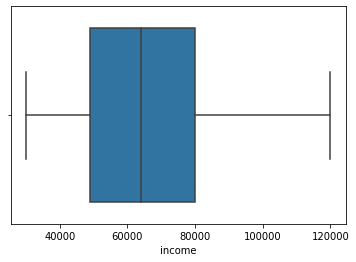

In [13]:
sns.boxplot(data=profile, x='income')

In [14]:
profile['became_member_on'] = pd.to_datetime(profile['became_member_on'].astype(str), format='%Y%m%d')
profile['became_member_on'].head()

1    2017-07-15
3    2017-05-09
5    2018-04-26
8    2018-02-09
12   2017-11-11
Name: became_member_on, dtype: datetime64[ns]

In [15]:
profile['year'] = profile['became_member_on'].dt.year
profile['month'] = profile['became_member_on'].dt.month
profile['day']=profile['became_member_on'].dt.day_name()
profile['membership_days'] = (pd.to_datetime('today') - profile['became_member_on']).astype('timedelta64[D]').astype(int)

Text(0, 0.5, 'income')

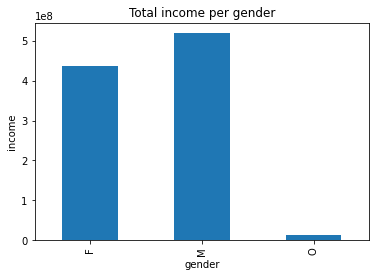

In [16]:
profile.groupby('gender').sum()['income'].plot(kind='bar')
plt.title('Total income per gender')
plt.ylabel('income')

In [17]:
profile['age_group'] = pd.cut(x=profile['age'], bins=[18, 20, 40, 60, 101],
                    labels=['Teenage(0-19)', 'Young(20-39)','Middle-age(40-59)',
                            'Old(60-100)'], include_lowest=True)
profile['age_group']

1        Middle-age(40-59)
3              Old(60-100)
5              Old(60-100)
8              Old(60-100)
12       Middle-age(40-59)
               ...        
16995    Middle-age(40-59)
16996          Old(60-100)
16997    Middle-age(40-59)
16998          Old(60-100)
16999          Old(60-100)
Name: age_group, Length: 14820, dtype: category
Categories (4, object): ['Teenage(0-19)' < 'Young(20-39)' < 'Middle-age(40-59)' < 'Old(60-100)']

In [18]:
from sklearn.preprocessing import LabelEncoder

profile = profile.copy(deep = True)
le_age = LabelEncoder()
profile['age_group'] = le_age.fit_transform(profile['age_group'])
profile.head(5)

,gender,age,id,became_member_on,income,year,month,day,membership_days,age_group
1,F,55,0610b486422d4921ae7d2bf64640c50b,2017-07-15,112000.0,2017,7,Saturday,1730,0
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,2017-05-09,100000.0,2017,5,Tuesday,1797,1
5,M,68,e2127556f4f64592b11af22de27a7932,2018-04-26,70000.0,2018,4,Thursday,1445,1
8,M,65,389bc3fa690240e798340f5a15918d5c,2018-02-09,53000.0,2018,2,Friday,1521,1
12,M,58,2eeac8d8feae4a8cad5a6af0499a211d,2017-11-11,51000.0,2017,11,Saturday,1611,0


In [19]:
profile['income_group'] = pd.cut(x=profile['income'], bins=[30000, 50000, 75000, 100000, 120000],
                    labels=['30k-50k', '50k-75k','75k-1L',
                            'more than 1L'], include_lowest=True)
profile['income_group']

1        more than 1L
3              75k-1L
5             50k-75k
8             50k-75k
12            50k-75k
             ...     
16995         50k-75k
16996         50k-75k
16997         50k-75k
16998         30k-50k
16999          75k-1L
Name: income_group, Length: 14820, dtype: category
Categories (4, object): ['30k-50k' < '50k-75k' < '75k-1L' < 'more than 1L']

In [20]:
from sklearn.preprocessing import LabelEncoder

profile = profile.copy(deep = True)
le_in = LabelEncoder()
profile['income_group'] = le_in.fit_transform(profile['income_group'])
profile.head(5)

,gender,age,id,became_member_on,income,year,month,day,membership_days,age_group,income_group
1,F,55,0610b486422d4921ae7d2bf64640c50b,2017-07-15,112000.0,2017,7,Saturday,1730,0,3
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,2017-05-09,100000.0,2017,5,Tuesday,1797,1,2
5,M,68,e2127556f4f64592b11af22de27a7932,2018-04-26,70000.0,2018,4,Thursday,1445,1,1
8,M,65,389bc3fa690240e798340f5a15918d5c,2018-02-09,53000.0,2018,2,Friday,1521,1,1
12,M,58,2eeac8d8feae4a8cad5a6af0499a211d,2017-11-11,51000.0,2017,11,Saturday,1611,0,1


In [21]:
profile = profile.drop(['age','income'], axis=1)

In [22]:
transcript['time_group'] = pd.cut(x=transcript['time'], bins=[0, 100, 200, 300, 400, 500,600,700,800], include_lowest=True,
                    labels=['0-100 days', '100-200 days', '200-300 days', '300-400 days', '400-500 days', '500-600 days', '600-700 days', '700-800 days'])
transcript['time_group'] 

0           0-100 days
1           0-100 days
2           0-100 days
3           0-100 days
4           0-100 days
              ...     
306529    700-800 days
306530    700-800 days
306531    700-800 days
306532    700-800 days
306533    700-800 days
Name: time_group, Length: 306534, dtype: category
Categories (8, object): ['0-100 days' < '100-200 days' < '200-300 days' < '300-400 days' < '400-500 days' < '500-600 days' < '600-700 days' < '700-800 days']

In [23]:
from sklearn.preprocessing import LabelEncoder

transcript = transcript.copy(deep = True)
le_id = LabelEncoder()
transcript['time_group'] = le_id.fit_transform(transcript['time_group'])
transcript.head(5)
transcript

,person,event,value,time,time_group
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0,0
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0,0
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0,0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0,0
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0,0
...,...,...,...,...,...
306529,b3a1272bc9904337b331bf348c3e8c17,transaction,{'amount': 1.5899999999999999},714,7
306530,68213b08d99a4ae1b0dcb72aebd9aa35,transaction,{'amount': 9.53},714,7
306531,a00058cf10334a308c68e7631c529907,transaction,{'amount': 3.61},714,7
306532,76ddbd6576844afe811f1a3c0fbb5bec,transaction,{'amount': 3.5300000000000002},714,7


In [24]:
transcript = transcript.drop(['time'], axis=1)

In [25]:
transcript.rename(columns={'person':'id'}, inplace=True)

In [26]:
df = pd.merge(profile, transcript, on='id')
df = df.drop(['became_member_on'], axis=1)
df

,gender,id,year,month,day,membership_days,age_group,income_group,event,value,time_group
0,F,0610b486422d4921ae7d2bf64640c50b,2017,7,Saturday,1730,0,3,transaction,{'amount': 21.51},0
1,F,0610b486422d4921ae7d2bf64640c50b,2017,7,Saturday,1730,0,3,transaction,{'amount': 32.28},1
2,F,0610b486422d4921ae7d2bf64640c50b,2017,7,Saturday,1730,0,3,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},4
3,F,0610b486422d4921ae7d2bf64640c50b,2017,7,Saturday,1730,0,3,offer received,{'offer id': '3f207df678b143eea3cee63160fa8bed'},5
4,F,0610b486422d4921ae7d2bf64640c50b,2017,7,Saturday,1730,0,3,transaction,{'amount': 23.22},5
...,...,...,...,...,...,...,...,...,...,...,...
272659,F,e4052622e5ba45a8b96b59aba68cf068,2017,7,Saturday,1723,1,2,offer completed,{'offer_id': 'f19421c1d4aa40978ebb69ca19b0e20d...,4
272660,F,e4052622e5ba45a8b96b59aba68cf068,2017,7,Saturday,1723,1,2,transaction,{'amount': 19.47},4
272661,F,e4052622e5ba45a8b96b59aba68cf068,2017,7,Saturday,1723,1,2,offer viewed,{'offer id': 'f19421c1d4aa40978ebb69ca19b0e20d'},5
272662,F,e4052622e5ba45a8b96b59aba68cf068,2017,7,Saturday,1723,1,2,offer received,{'offer id': '3f207df678b143eea3cee63160fa8bed'},5


In [27]:
#map the offer_id from df with id in portfolio

#create dict such that offers['offer_id']= offerName_difficulty_duration
offers=dict()
for offer, i, diff, dur in portfolio[['offer_type', 'id', 'difficulty', 'duration']].values:
    offers[i]= f'{offer}_{diff}_{dur}'


def value_col(col):
    """
    extract offer_id from value column and mapped it to the offer name
    
    input- value column
    
    output-  mapped offer names
    """
    value_type= col.split(':')[0].replace("'", "").replace('{', "")
    
    if value_type == 'offer id':
        value= col.split(':')[1].replace("'", "").replace('}', "").strip()
        return offers[value]
    elif value_type == 'offer_id':
        value= col.split(':')[1].split(',')[0].replace("'", "").strip()
        return offers[value]
    else:
        return 'None'

In [28]:
#get offer names
df['offer']= df['value'].apply(value_col)

In [29]:
def value_col_id(col):
    """
    extract offer_id from value column
    
    input- value column
    
    output- offer_ids
    """
    value_type= col.split(':')[0].replace("'", "").replace('{', "")
    
    if value_type == 'offer id':
        value= col.split(':')[1].replace("'", "").replace('}', "").strip()
        return value
    elif value_type == 'offer_id':
        value= col.split(':')[1].split(',')[0].replace("'", "").strip()
        return value
    else:
        return 'None'

In [30]:
#get offer ids
df['offer_id']= df['value'].apply(value_col_id)

In [31]:
def value_col_trans(col):
    """
    get transaction amount from value column
    
    input- value column
    
    output- transaction amount
    """
    value_type= col.split(':')[0].replace("'", "").replace('{', "")
    
    if value_type == 'amount':
        value= col.split(':')[1].replace("'", "").replace('}', "").strip()
        return np.round(float(value), 2)
    else:
        return np.nan

In [32]:
#get transaction amount
df['amount']= df['value'].apply(value_col_trans)

In [33]:
df = df.drop(['value'], axis=1)

In [34]:
df['offer'] = df['offer'].str.replace('_', '')
df['offer'] = df['offer'].str.replace('\d+', '')
df

,gender,id,year,month,day,membership_days,age_group,income_group,event,time_group,offer,offer_id,amount
0,F,0610b486422d4921ae7d2bf64640c50b,2017,7,Saturday,1730,0,3,transaction,0,None,None,21.51
1,F,0610b486422d4921ae7d2bf64640c50b,2017,7,Saturday,1730,0,3,transaction,1,None,None,32.28
2,F,0610b486422d4921ae7d2bf64640c50b,2017,7,Saturday,1730,0,3,offer received,4,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN
3,F,0610b486422d4921ae7d2bf64640c50b,2017,7,Saturday,1730,0,3,offer received,5,informational,3f207df678b143eea3cee63160fa8bed,NaN
4,F,0610b486422d4921ae7d2bf64640c50b,2017,7,Saturday,1730,0,3,transaction,5,None,None,23.22
...,...,...,...,...,...,...,...,...,...,...,...,...,...
272659,F,e4052622e5ba45a8b96b59aba68cf068,2017,7,Saturday,1723,1,2,offer completed,4,bogo,f19421c1d4aa40978ebb69ca19b0e20d,NaN
272660,F,e4052622e5ba45a8b96b59aba68cf068,2017,7,Saturday,1723,1,2,transaction,4,None,None,19.47
272661,F,e4052622e5ba45a8b96b59aba68cf068,2017,7,Saturday,1723,1,2,offer viewed,5,bogo,f19421c1d4aa40978ebb69ca19b0e20d,NaN
272662,F,e4052622e5ba45a8b96b59aba68cf068,2017,7,Saturday,1723,1,2,offer received,5,informational,3f207df678b143eea3cee63160fa8bed,NaN


In [35]:
from sklearn.preprocessing import LabelEncoder

df = df.copy(deep = True)
le_offer = LabelEncoder()
df['offer'] = le_offer.fit_transform(df['offer'])
df.head(5)
df

,gender,id,year,month,day,membership_days,age_group,income_group,event,time_group,offer,offer_id,amount
0,F,0610b486422d4921ae7d2bf64640c50b,2017,7,Saturday,1730,0,3,transaction,0,0,None,21.51
1,F,0610b486422d4921ae7d2bf64640c50b,2017,7,Saturday,1730,0,3,transaction,1,0,None,32.28
2,F,0610b486422d4921ae7d2bf64640c50b,2017,7,Saturday,1730,0,3,offer received,4,1,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN
3,F,0610b486422d4921ae7d2bf64640c50b,2017,7,Saturday,1730,0,3,offer received,5,3,3f207df678b143eea3cee63160fa8bed,NaN
4,F,0610b486422d4921ae7d2bf64640c50b,2017,7,Saturday,1730,0,3,transaction,5,0,None,23.22
...,...,...,...,...,...,...,...,...,...,...,...,...,...
272659,F,e4052622e5ba45a8b96b59aba68cf068,2017,7,Saturday,1723,1,2,offer completed,4,1,f19421c1d4aa40978ebb69ca19b0e20d,NaN
272660,F,e4052622e5ba45a8b96b59aba68cf068,2017,7,Saturday,1723,1,2,transaction,4,0,None,19.47
272661,F,e4052622e5ba45a8b96b59aba68cf068,2017,7,Saturday,1723,1,2,offer viewed,5,1,f19421c1d4aa40978ebb69ca19b0e20d,NaN
272662,F,e4052622e5ba45a8b96b59aba68cf068,2017,7,Saturday,1723,1,2,offer received,5,3,3f207df678b143eea3cee63160fa8bed,NaN


In [36]:
event = df.event.value_counts().reset_index()
event.columns = ['event', 'count']
fig = px.pie(event, values='count', names='event', title='Event',
             color_discrete_sequence=['blue', 'light green'])
fig.show()

In [37]:
transaction_df = df[df.event == 'transaction']
offer_completed_df = df[df.event == 'offer completed']
offer_viewed_df = df[df.event == 'offer viewed']
offers_received_df = df[df.event == 'offer received']

In [38]:
offers_received_df

,gender,id,year,month,day,membership_days,age_group,income_group,event,time_group,offer,offer_id,amount
2,F,0610b486422d4921ae7d2bf64640c50b,2017,7,Saturday,1730,0,3,offer received,4,1,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN
3,F,0610b486422d4921ae7d2bf64640c50b,2017,7,Saturday,1730,0,3,offer received,5,3,3f207df678b143eea3cee63160fa8bed,NaN
6,F,78afa995795e4d85b5d9ceeca43f5fef,2017,5,Tuesday,1797,1,2,offer received,0,1,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN
11,F,78afa995795e4d85b5d9ceeca43f5fef,2017,5,Tuesday,1797,1,2,offer received,1,3,5a8bc65990b245e5a138643cd4eb9837,NaN
16,F,78afa995795e4d85b5d9ceeca43f5fef,2017,5,Tuesday,1797,1,2,offer received,4,1,ae264e3637204a6fb9bb56bc8210ddfd,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
272643,F,9dc1421481194dcd9400aec7c9ae6366,2016,3,Monday,2225,1,0,offer received,5,1,ae264e3637204a6fb9bb56bc8210ddfd,NaN
272650,F,e4052622e5ba45a8b96b59aba68cf068,2017,7,Saturday,1723,1,2,offer received,0,2,2298d6c36e964ae4a3e7e9706d1fb8c2,NaN
272656,F,e4052622e5ba45a8b96b59aba68cf068,2017,7,Saturday,1723,1,2,offer received,3,3,3f207df678b143eea3cee63160fa8bed,NaN
272657,F,e4052622e5ba45a8b96b59aba68cf068,2017,7,Saturday,1723,1,2,offer received,4,1,f19421c1d4aa40978ebb69ca19b0e20d,NaN


In [39]:
offers_received_df.rename(columns={'id':'customer_id'}, inplace=True)
offers_received_df

,gender,customer_id,year,month,day,membership_days,age_group,income_group,event,time_group,offer,offer_id,amount
2,F,0610b486422d4921ae7d2bf64640c50b,2017,7,Saturday,1730,0,3,offer received,4,1,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN
3,F,0610b486422d4921ae7d2bf64640c50b,2017,7,Saturday,1730,0,3,offer received,5,3,3f207df678b143eea3cee63160fa8bed,NaN
6,F,78afa995795e4d85b5d9ceeca43f5fef,2017,5,Tuesday,1797,1,2,offer received,0,1,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN
11,F,78afa995795e4d85b5d9ceeca43f5fef,2017,5,Tuesday,1797,1,2,offer received,1,3,5a8bc65990b245e5a138643cd4eb9837,NaN
16,F,78afa995795e4d85b5d9ceeca43f5fef,2017,5,Tuesday,1797,1,2,offer received,4,1,ae264e3637204a6fb9bb56bc8210ddfd,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
272643,F,9dc1421481194dcd9400aec7c9ae6366,2016,3,Monday,2225,1,0,offer received,5,1,ae264e3637204a6fb9bb56bc8210ddfd,NaN
272650,F,e4052622e5ba45a8b96b59aba68cf068,2017,7,Saturday,1723,1,2,offer received,0,2,2298d6c36e964ae4a3e7e9706d1fb8c2,NaN
272656,F,e4052622e5ba45a8b96b59aba68cf068,2017,7,Saturday,1723,1,2,offer received,3,3,3f207df678b143eea3cee63160fa8bed,NaN
272657,F,e4052622e5ba45a8b96b59aba68cf068,2017,7,Saturday,1723,1,2,offer received,4,1,f19421c1d4aa40978ebb69ca19b0e20d,NaN


In [40]:
offers_received_df.rename(columns={'offer_id':'id'}, inplace=True)
offers_received_df

,gender,customer_id,year,month,day,membership_days,age_group,income_group,event,time_group,offer,id,amount
2,F,0610b486422d4921ae7d2bf64640c50b,2017,7,Saturday,1730,0,3,offer received,4,1,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN
3,F,0610b486422d4921ae7d2bf64640c50b,2017,7,Saturday,1730,0,3,offer received,5,3,3f207df678b143eea3cee63160fa8bed,NaN
6,F,78afa995795e4d85b5d9ceeca43f5fef,2017,5,Tuesday,1797,1,2,offer received,0,1,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN
11,F,78afa995795e4d85b5d9ceeca43f5fef,2017,5,Tuesday,1797,1,2,offer received,1,3,5a8bc65990b245e5a138643cd4eb9837,NaN
16,F,78afa995795e4d85b5d9ceeca43f5fef,2017,5,Tuesday,1797,1,2,offer received,4,1,ae264e3637204a6fb9bb56bc8210ddfd,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
272643,F,9dc1421481194dcd9400aec7c9ae6366,2016,3,Monday,2225,1,0,offer received,5,1,ae264e3637204a6fb9bb56bc8210ddfd,NaN
272650,F,e4052622e5ba45a8b96b59aba68cf068,2017,7,Saturday,1723,1,2,offer received,0,2,2298d6c36e964ae4a3e7e9706d1fb8c2,NaN
272656,F,e4052622e5ba45a8b96b59aba68cf068,2017,7,Saturday,1723,1,2,offer received,3,3,3f207df678b143eea3cee63160fa8bed,NaN
272657,F,e4052622e5ba45a8b96b59aba68cf068,2017,7,Saturday,1723,1,2,offer received,4,1,f19421c1d4aa40978ebb69ca19b0e20d,NaN


In [41]:
df1 = pd.merge(offers_received_df, portfolio, on='id')
df1.head(2)

,gender,customer_id,year,month,day,membership_days,age_group,income_group,event,time_group,offer,id,amount,reward,channels,difficulty,duration,offer_type
0,F,0610b486422d4921ae7d2bf64640c50b,2017,7,Saturday,1730,0,3,offer received,4,1,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,5,"['web', 'email', 'mobile']",5,7,bogo
1,F,78afa995795e4d85b5d9ceeca43f5fef,2017,5,Tuesday,1797,1,2,offer received,0,1,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,5,"['web', 'email', 'mobile']",5,7,bogo


In [42]:
from sklearn.preprocessing import LabelEncoder

df1 = df1.copy(deep = True)
le_id = LabelEncoder()
df1['customer_id'] = le_id.fit_transform(df1['customer_id'])


In [43]:
from sklearn.preprocessing import LabelEncoder

df1 = df1.copy(deep = True)
le_id = LabelEncoder()
df1['id'] = le_id.fit_transform(df1['id'])


In [44]:
users = df1.copy(deep = True) 
items = df1.copy(deep = True)
rewards = df1.copy(deep = True)
users = df1.drop(['year','day', 'month', 'amount', 'offer','id', 'event', 'time_group', 'offer', 'reward', 'channels', 'difficulty', 'duration'],axis=1)
items = df1.drop(['year','day', 'month', 'amount', 'event', 'customer_id', 'gender', 'age_group', 'income_group', 'time_group', 'reward',  'difficulty', 'duration'],axis=1)
rewards = df1.drop(['year','day', 'month', 'amount', 'event', 'gender', 'age_group', 'income_group', 'time_group','membership_days',  'difficulty', 'duration'],axis=1)

In [45]:
items.head(2)

,membership_days,offer,id,channels,offer_type
0,1730,1,6,"['web', 'email', 'mobile']",bogo
1,1797,1,6,"['web', 'email', 'mobile']",bogo


In [46]:
users.head(2)

,gender,customer_id,membership_days,age_group,income_group,offer_type
0,F,345,1730,0,3,bogo
1,F,6957,1797,1,2,bogo


In [47]:
rewards.head(2)

,customer_id,offer,id,reward,channels,offer_type
0,345,1,6,5,"['web', 'email', 'mobile']",bogo
1,6957,1,6,5,"['web', 'email', 'mobile']",bogo


In [48]:
n_users = users.customer_id.unique().shape[0]
n_items = items.id.unique().shape[0]

In [49]:
data_matrix = np.zeros((n_users, n_items))
for line in rewards.itertuples():
    data_matrix[line[1]-1, line[2]-1] = line[3]

In [50]:
from sklearn.metrics.pairwise import pairwise_distances 
user_similarity = pairwise_distances(data_matrix, metric='cosine')
item_similarity = pairwise_distances(data_matrix.T, metric='cosine')

In [51]:
def predict(rewards, similarity, type='user'):
    
    if type == 'user':
        mean_user_reward = rewards.mean(axis=1).reshape(-1,1)
        #We use np.newaxis so that mean_user_rating has same format as ratings
        
        rewards_diff = (rewards - mean_user_reward)
        pred = mean_user_reward + similarity.dot(rewards_diff) / np.array([np.abs(similarity).sum(axis=1)]).T
    
    elif type == 'item':
        pred = rewards.dot(similarity) / np.array([np.abs(similarity).sum(axis=1)])
    
    return pred

In [52]:
user_prediction = predict(data_matrix, user_similarity, type='user')
item_prediction = predict(data_matrix, item_similarity, type='item')

In [53]:
user_prediction

array([[ 4.15205514,  3.84194571,  1.77499772, ...,  0.17585735,
         0.17585735,  0.17585735],
       [ 6.19049853,  1.6157427 ,  3.18941602, ...,  1.00062039,
         1.00062039,  1.00062039],
       [ 3.89136902,  4.03894264,  2.4439027 , ...,  0.51796938,
         0.51796938,  0.51796938],
       ...,
       [ 3.84683782,  4.2277768 ,  2.33353227, ...,  0.37026473,
         0.37026473,  0.37026473],
       [ 2.77268308,  2.73914233,  3.09565142, ..., -0.37249669,
        -0.37249669, -0.37249669],
       [ 5.9751635 ,  2.14269694,  3.79933711, ...,  1.44040035,
         1.44040035,  1.44040035]])

In [54]:
item_prediction

array([[0.20686971, 0.76445606, 0.24626513, ..., 1.22222222, 1.22222222,
        1.22222222],
       [0.82131561, 0.63252127, 0.84545619, ..., 2.        , 2.        ,
        2.        ],
       [0.27514148, 0.89639086, 0.40405122, ..., 1.55555556, 1.55555556,
        1.55555556],
       ...,
       [0.20686971, 0.89639086, 0.32835351, ..., 1.44444444, 1.44444444,
        1.44444444],
       [0.        , 0.39580439, 0.24626513, ..., 0.66666667, 0.66666667,
        0.66666667],
       [0.82131561, 0.89639086, 1.00963294, ..., 2.44444444, 2.44444444,
        2.44444444]])